# Анализ оттока клиентов сети фитнес-клубов

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.  

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
1. Данные клиента за предыдущий до проверки факта оттока месяц:
    - `gender` — пол;
    - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
    - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - `Phone` — наличие контактного телефона;
    - `Age` — возраст;
    - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    - `Group_visits` — факт посещения групповых занятий;
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3. `Churn` — факт оттока в текущем месяце.

План действий:
- загрузить и просмотреть данные;
- выполнить предобработку данных и EDA;
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

## Загрузка и просмотр данных

Загрузим датасет, сохраним его в датафрейм и изучим общую информацию о данных.

In [1]:
# Подключение всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

1. Размер данных: 4000 записей (строк) и 14 признаков (столбцов).
2. Типы данных:
    - 10 признаков имеют тип int64 (целочисленные данные).
    - 4 признака имеют тип float64 (вещественные данные).
3. Особенности:
    - Данные полные, без пропусков.
    - Все признаки закодированы в числовом формате, что упрощает их обработку и анализ (нет категориальных признаков).
    - Целевой признак (`Churn`) — бинарный, что указывает на задачу бинарной классификации.

Таким образом, мы загрузили и изучили исходные данные.

## Предобработка данных

Начнем с преобразования названий столбцов к "змеиному" формату.

In [4]:
# Преобразование названий столбцов в snake_case
data.columns = [col.lower().replace(' ', '_') for col in data.columns]

# Проверка успешности преобразования
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверим в явном виде данные на пропуски.

In [5]:
# Проверка данных на пропуски
missing_values = data.isnull().sum()
missing_values

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Теперь проверим данные на дубликаты.

In [6]:
# Проверка данных на дубликаты
duplicates = data.duplicated().sum()
print(f"Количество дубликатов в данных: {duplicates}")

Количество дубликатов в данных: 0


Проверку на неявные дубли можно не выполнять, так как все признаки числовые.

Предобработка данных выполнена, теперь можно переходить к анализу данных.

## Исследовательский анализ данных (EDA)

Изучим информацию о средних значениях и стандартных отклонениях.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Большинство клиентов — молодые люди (в среднем 29 лет), около 85% живут или работают рядом с фитнес-центром, 51% — женщины. Средняя длительность контракта составляет около 4.7 месяцев, а время с момента первой записи — 3.7 месяца. Средняя частота посещений — 1.8 раза в неделю, с высокой вариативностью. Дополнительные расходы также различаются значительно, от минимальных до более 500. Около 26.5% клиентов находятся в оттоке, что указывает на умеренно несбалансированные классы.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [8]:
# Средние значения признаков в группах оттока и оставшихся
grouped_means = data.groupby('churn').mean().reset_index()
print("Средние значения признаков в группах оттока и оставшихся:")
display(grouped_means)

Средние значения признаков в группах оттока и оставшихся:


,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Клиенты, оставшиеся с фитнес-центром, чаще проживают рядом (87.3% против 76.8%), работают в компаниях-партнёрах (53.4% против 35.5%) и приходили по акции "Приведи друга" (35.4% против 18.4%). Они используют более длительные контракты (5.75 месяца против 1.73), имеют больший стаж (4.71 месяца против 0.99) и выше средняя частота посещений (2.02 против 1.47). Ушедшие клиенты моложе (27 лет против 30), реже посещают групповые занятия и тратят меньше на дополнительные услуги.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался.

In [9]:
# Разделение на категориальные и числовые признаки
categorical_features = [col for col in data.columns if data[col].nunique() <= 10 and col != 'churn']
numerical_features = [col for col in data.columns if col not in categorical_features and col != 'churn']

print("Категориальные признаки:", categorical_features)
print("Числовые признаки:", numerical_features)

Категориальные признаки: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
Числовые признаки: ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


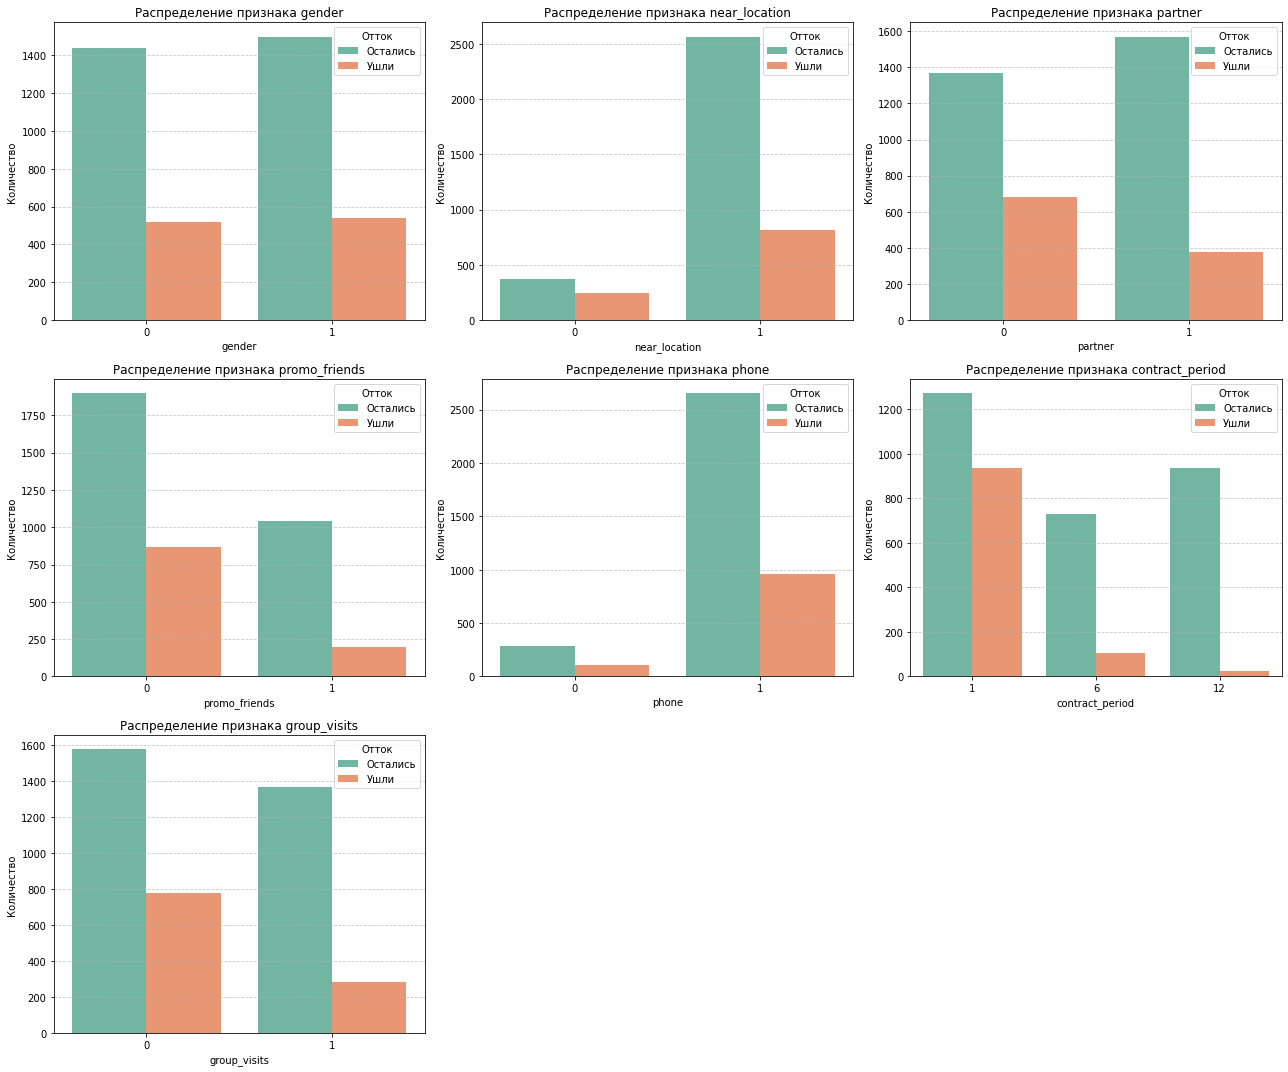

In [10]:
# Построение графиков
n_cols = 3  # Количество графиков в строке
n_rows = math.ceil(len(categorical_features) / n_cols)  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=data, x=feature, hue='churn', palette='Set2', ax=axes[i])
    axes[i].set_title(f'Распределение признака {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Количество')
    axes[i].legend(title='Отток', labels=['Остались', 'Ушли'])
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Убираем пустые подграфики, если их больше, чем признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

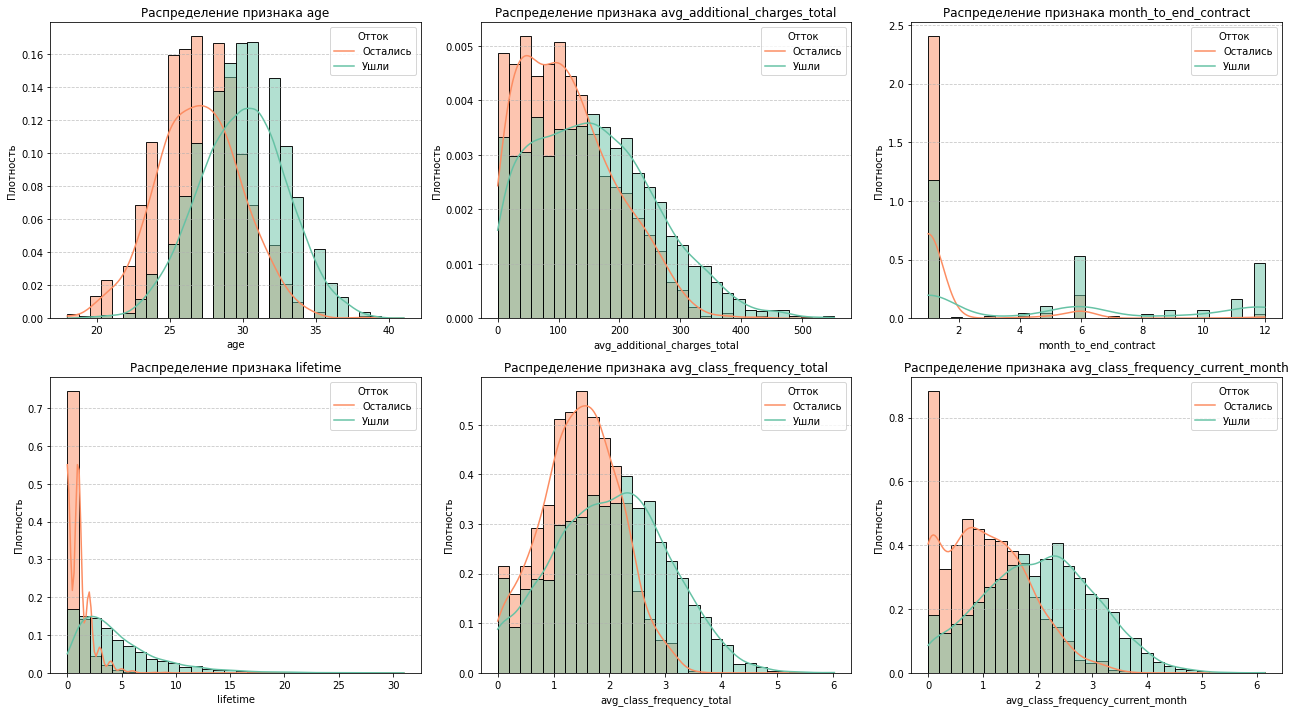

In [11]:
n_rows = math.ceil(len(numerical_features) / n_cols)  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=data, x=feature, hue='churn', kde=True, stat='density', common_norm=False, palette='Set2', bins=30, ax=axes[i])
    axes[i].set_title(f'Распределение признака {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend(title='Отток', labels=['Остались', 'Ушли'])

# Убираем пустые подграфики, если их больше, чем признаков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ всех графиков показывает, что клиенты, оставшиеся с фитнес-центром, имеют более продолжительное время использования услуг (lifetime) и выше среднюю частоту посещений как за всё время, так и за последний месяц. Ушедшие клиенты чаще прекращают посещения ещё в начале использования и характеризуются низкой активностью. Для оставшихся также характерны более длительные контракты, близость к фитнес-центру и участие в программах или акциях. Эти различия позволяют выделить ключевые группы риска и разработать целевые меры для их удержания.

Построим матрицу корреляций признаков, отобразим её и проанализируем.

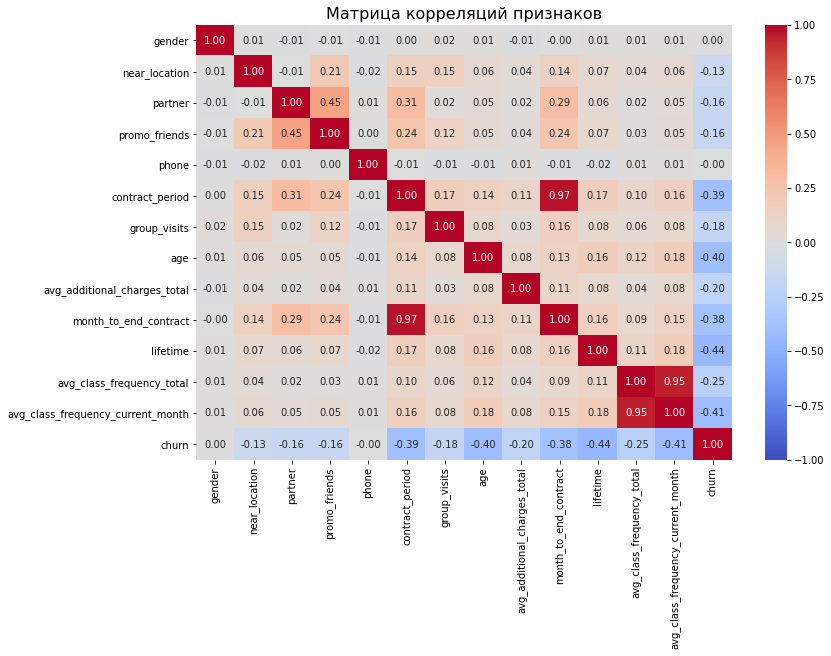

In [12]:
# Расчёт матрицы корреляций
correlation_matrix = data.corr()

# Построение тепловой карты корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Матрица корреляций признаков", fontsize=16)
plt.show()

Матрица корреляций показывает, что отток (`churn`) наиболее сильно отрицательно коррелирует с такими признаками, как `lifetime` (-0.44), `avg_class_frequency_current_month` (0.41), `age` (-0.40), `contract_period` (-0.39) и `month_to_end_contract` (-0.38). Это указывает на то, что более молодые клиенты с коротким сроком контракта и меньшим временем использования услуг фитнес-центра имеют больший риск ухода. Также видна высокая взаимосвязь между парами `contract_period` и `month_to_end_contract` (0.97) и `avg_class_frequency_current_month` и `avg_class_frequency_total` (0.95), что требует осторожности при использовании этих признаков в моделях.

Исследовательский анализ данных выполнен, перейдем к построению модели прогнозирования.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Разобьем данные на обучающую и валидационную выборку.

In [13]:
# Определим признаки (X) и целевой столбец (y)
X = data.drop(columns=['churn'])  # Признаки
y = data['churn']  # Целевой признак

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер обучающей выборки: (3200, 13)
Размер валидационной выборки: (800, 13)


Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

In [14]:
# Стандартизация данных
scaler = StandardScaler()

# Применяем стандартизацию к количественным признакам
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Обучение логистической регрессии
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled)

# Оценка метрик для логистической регрессии
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)

In [15]:
# Случайный лес
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)

# Оценка метрик для случайного леса
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)

Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сравним по ним модели.

In [16]:
# Вывод результатов
print("Метрики для логистической регрессии:")
print(f"Accuracy: {accuracy_log_reg:.2f}")
print(f"Precision: {precision_log_reg:.2f}")
print(f"Recall: {recall_log_reg:.2f}")

print("\nМетрики для случайного леса:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")

Метрики для логистической регрессии:
Accuracy: 0.93
Precision: 0.88
Recall: 0.83

Метрики для случайного леса:
Accuracy: 0.93
Precision: 0.89
Recall: 0.83


Случайный лес и логистическая регрессия демонстрируют одинаковую точность (Accuracy — 0.93) и полноту (Recall — 0.83). Однако случайный лес показывает немного более высокую точность предсказаний положительного класса (Precision — 0.89) по сравнению с логистической регрессией (Precision — 0.88). Таким образом, случайный лес обеспечивает немного лучшую производительность в задаче классификации.

## Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов).

Для начала стандартизируем данные.

In [17]:
# Отложим столбец с оттоком
X_clustering = data.drop(columns=['churn'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

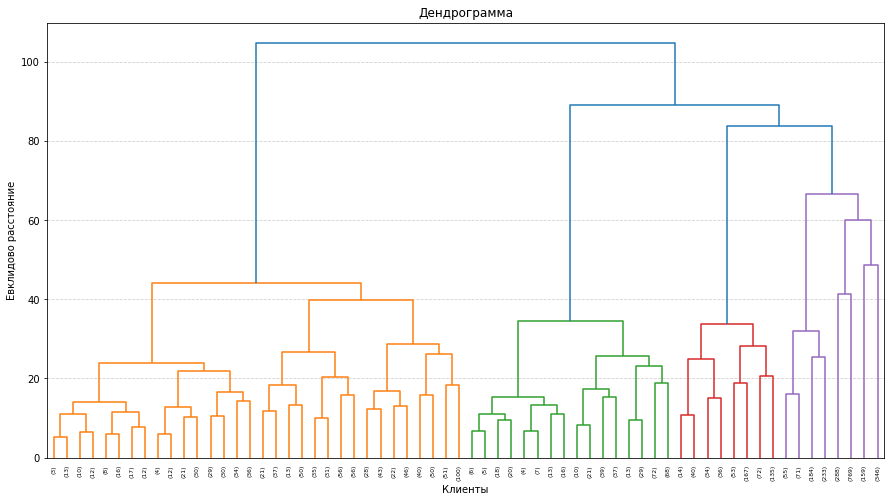

In [18]:
# Построение матрицы расстояний
linked = linkage(X_scaled, method='ward')

# Построение дендрограммы
plt.figure(figsize=(15, 8))
dendrogram(linked, truncate_mode='level', p=5)  # Отображение только 5 уровней
plt.title("Дендрограмма")
plt.xlabel("Клиенты")
plt.ylabel("Евклидово расстояние")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

На основе дендрограммы видно, что данные можно разделить на более чем два кластера, несмотря на ожидание бинарной классификации. Наиболее очевидно выделяются 4 крупных кластера, так как в этих точках происходит резкий рост расстояний между объединяемыми группами. Это говорит о том, что клиенты фитнес-центра обладают большей разнообразностью, чем предполагалось, и можно углубить анализ для более детального изучения их характеристик.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять `n=5`, чтобы результаты можно было сравнивать с результатами остальных студентов.

In [19]:
# Обучение модели K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Прогноз кластеров
clusters = kmeans.predict(X_scaled)

# Добавление кластеров в исходные данные
data['cluster'] = clusters

Посмотрим на средние значения признаков для кластеров.

In [20]:
# Анализ средних значений признаков по кластерам
cluster_means = data.groupby('cluster').mean().reset_index()

# Вывод результатов
pd.options.display.float_format = '{:.2f}'.format  # Округление до 2 знаков после запятой
print("Средние значения признаков по кластерам:")
cluster_means

Средние значения признаков по кластерам:


,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.50,0.95,0.83,1.00,1.00,3.10,0.45,29.10,141.77,2.89,3.77,1.77,1.67,0.25
1,1,0.55,0.85,0.26,0.05,1.00,2.61,0.44,30.01,159.77,2.42,4.78,2.75,2.73,0.09
2,2,0.50,0.94,0.74,0.48,1.00,11.85,0.55,29.91,163.51,10.81,4.68,2.01,2.00,0.02
3,3,0.49,0.72,0.30,0.02,1.00,1.91,0.28,28.08,129.50,1.82,2.20,1.23,0.97,0.57
4,4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27


1. Кластер 0:
    - Высокая доля клиентов, привлечённых через акции "Приведи друга" (100%).
    - Невысокая частота посещений (1.77 раза в неделю в текущем месяце).
    - Средний возраст и умеренная длительность контракта (3.1 месяца).
2. Кластер 1:
    - Клиенты с наиболее активными посещениями (2.73 раза в неделю в текущем месяце) и минимальным уровнем оттока (9%).
    - Часто проживают или работают рядом с фитнес-центром (85%).
    - Предпочитают длительные контракты (в среднем 11.85 месяцев) и остаются дольше всех (средний lifetime — 10.81 месяца).
3. Кластер 2:
    - Очень высокая длительность контрактов (11.85 месяцев) и значительный стаж (lifetime — 10.81 месяца).
    - Минимальный отток (2%), что указывает на лояльную группу клиентов.
4. Кластер 3:
    - Группа с самым высоким оттоком (57%).
    - Молодые клиенты (средний возраст — 28 лет), короткие контракты (1.91 месяца), низкий уровень групповых занятий (28%) и редкие посещения (0.97 раза в неделю).
    - Самая уязвимая группа, нуждающаяся в особом внимании.
5. Кластер 4:
    - Средний уровень активности и оттока (27%).
    - Умеренные контракты (4.78 месяца), частота посещений ниже среднего (1.72 раза в неделю).
    
Кластеры явно различаются по уровню лояльности, активности и склонности к оттоку. Особенно выделяются кластеры 1 и 2 как лояльные группы, в то время как кластер 3 демонстрирует наибольшую уязвимость и высокий риск оттока. Эти данные можно использовать для разработки целевых стратегий удержания клиентов.

Построим распределения признаков для кластеров.

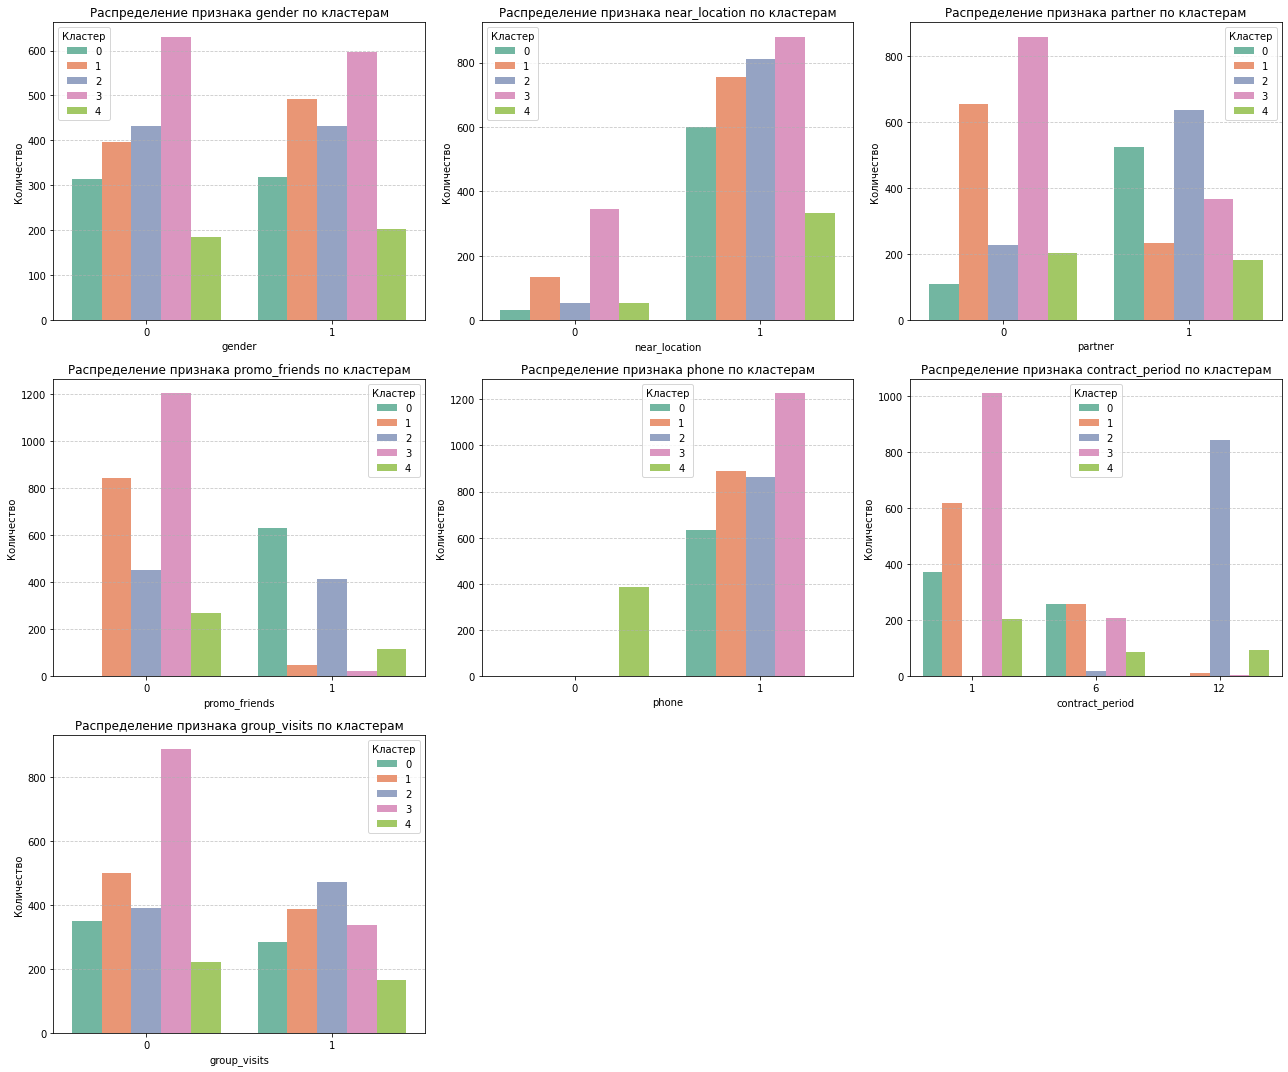

In [21]:
# Настройки подграфиков
n_cols = 3  # Количество графиков в строке
n_rows = math.ceil(len(categorical_features) / n_cols)  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=data, x=feature, hue='cluster', palette='Set2', ax=axes[i])
    axes[i].set_title(f'Распределение признака {feature} по кластерам')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Количество')
    axes[i].legend(title='Кластер')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Удаление пустых подграфиков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

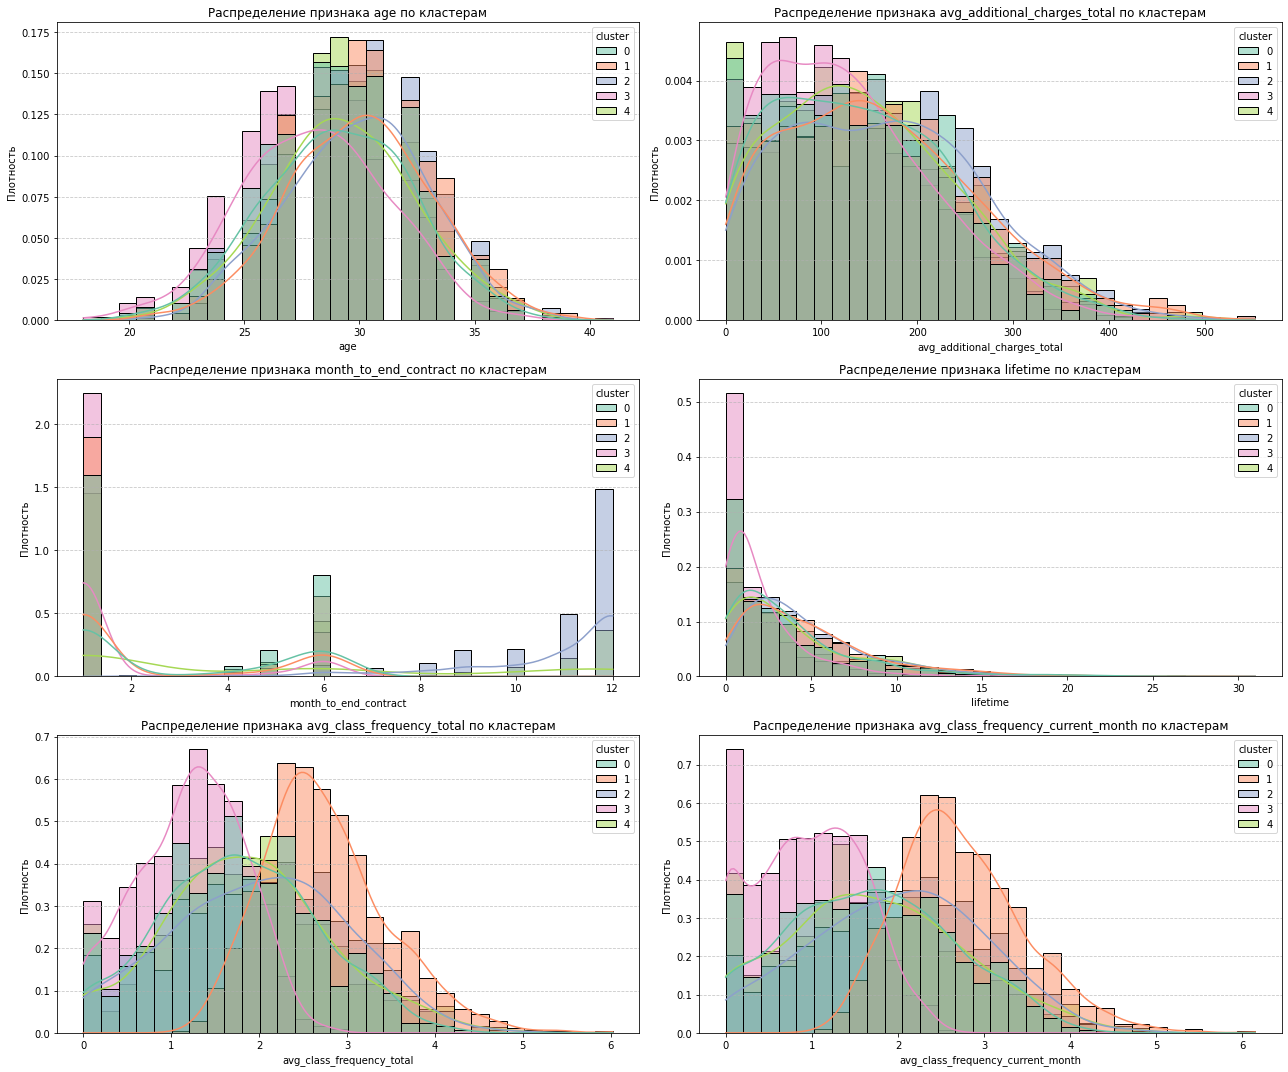

In [22]:
# Настройки подграфиков
n_cols = 2  # Количество графиков в строке
n_rows = math.ceil(len(numerical_features) / n_cols)  # Количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(
        data=data, x=feature, hue='cluster', kde=True, stat='density',
        common_norm=False, palette='Set2', bins=30, ax=axes[i]
    )
    axes[i].set_title(f'Распределение признака {feature} по кластерам')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Добавляем названия кластеров в легенду вручную
    handles, labels = axes[i].get_legend_handles_labels()
    if handles and labels:
        axes[i].legend(handles=handles, labels=[f'Кластер {label}' for label in labels], title='Кластер')

# Удаление пустых подграфиков
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ распределений показывает, что лояльные клиенты (кластеры 1 и 2) характеризуются долгосрочными контрактами, высокой активностью (частота посещений 2–3 раза в неделю), участием в акциях и дополнительными тратами. Они чаще проживают рядом с фитнес-центром и работают в компаниях-партнёрах. Напротив, клиенты из кластеров с высоким риском оттока (кластер 3) имеют короткий срок использования услуг, минимальную частоту посещений, короткие контракты и низкую вовлечённость. Эти различия подчёркивают ключевые признаки для таргетинга стратегий удержания.

Для каждого полученного кластера посчитаем долю оттока (ещё раз в явном виде).

In [23]:
# Группировка по кластерам и расчёт доли оттока
churn_rate_by_cluster = data.groupby('cluster')['churn'].mean().reset_index()

# Добавление количества клиентов в каждом кластере для наглядности
churn_rate_by_cluster['num_clients'] = data.groupby('cluster')['churn'].count().values

# Вывод результатов
pd.options.display.float_format = '{:.2f}'.format  # Форматирование вывода
print("Доля оттока и количество клиентов по кластерам:")
churn_rate_by_cluster

Доля оттока и количество клиентов по кластерам:


,cluster,churn,num_clients
0,0,0.25,633
1,1,0.09,889
2,2,0.02,865
3,3,0.57,1227
4,4,0.27,386


Кластеры существенно различаются по доле оттока. Наиболее надёжными являются кластеры 1 (9%) и 2 (2%), характеризующиеся высокой лояльностью и низким риском ухода. Кластер 3 имеет наибольшую долю оттока (57%) и включает клиентов с низкой вовлечённостью. Кластеры 0 (25%) и 4 (27%) занимают промежуточное положение, требуя умеренного внимания для удержания клиентов. Эти различия подчёркивают необходимость таргетированных стратегий для групп с высоким риском.

## Заключение и выводы

Сформулируем основные выводы и предложим рекомендации для стратегии взаимодействия с клиентами и их удержания.

Анализ данных фитнес-центра показал, что клиенты делятся на несколько групп с различным уровнем активности, лояльности и склонности к оттоку. Исходные данные содержали информацию о демографических характеристиках клиентов, длительности их контрактов, активности и дополнительных тратах. Данные были чистыми, без пропусков, что упростило их анализ. Признаки были разделены на числовые и категориальные для корректной визуализации, а числовые признаки масштабированы для обучения логистической регрессии.

В процессе работы были построены модели для прогнозирования оттока — логистическая регрессия и случайный лес. Логистическая регрессия показала высокие результаты (Accuracy — 93%, Precision — 88%, Recall — 83%), а случайный лес продемонстрировал аналогичные значения точности и полноты, но немного более высокую точность предсказания положительного класса (Precision — 89%). Это указывает на то, что случайный лес чуть лучше справляется с задачей, но обе модели достаточно надёжны.

Кластеризация клиентов с использованием метода K-Means выделила 5 групп с различными характеристиками. Надёжные клиенты (кластеры 1 и 2) имеют долгосрочные контракты, высокую частоту посещений и активно пользуются дополнительными услугами. В то время как клиенты из кластера 3 демонстрируют самый высокий риск оттока (57%) из-за низкой активности, краткосрочных контрактов и минимального времени использования услуг.

Рекомендуемые меры для удержания клиентов:

1. Персонализированное взаимодействие:
    - Для клиентов с высоким риском оттока (кластер 3) предложить акции и бонусы за продление контрактов, например, скидки на долгосрочные абонементы или дополнительные услуги.
2. Повышение вовлечённости:
    - Продвигать участие в групповых занятиях и специальных программах для менее активных клиентов (кластеры 0 и 4), например, через персональные приглашения или бонусные классы.
3. Программы лояльности:
    - Развивать программы лояльности для удержания надёжных клиентов (кластеры 1 и 2), включая эксклюзивные предложения на дополнительные услуги или продление контрактов.
4. Таргетинг по местоположению:
    - Разработать специальные предложения для клиентов, проживающих далеко от фитнес-центра, чтобы повысить их мотивацию к посещению.

Предложенные меры помогут повысить лояльность клиентов, снизить отток и обеспечить стабильный рост доходов фитнес-центра. Работа продемонстрировала, что детальный анализ данных и моделирование позволяют выявить ключевые группы клиентов и сформировать эффективные стратегии взаимодействия.